### Data exploration
Diogo Pessoa

Section dedicated to exploring the data and validating the added features. Using Visualizations to understand the aggregated data and the relationships between the chosen features.

In [ ]:
"""Uncomment this Section if running locally or working on this notebook and loading dataset directly here."""
# import os
# import sys
#
# from dotenv import load_dotenv
#
# # Load environment variables from a .env file
# load_dotenv()
# images_path = os.getenv('IMAGES_PATH')
# data_dir = os.getenv('DATA_COLLECTION_DIR')
#
# # Loading local helper modules
# module_path = os.path.abspath(os.path.join('..'))
# if module_path not in sys.path:
#     sys.path.append(module_path)
# # data_collection
# %run './data_collection.ipynb'
# # features engineering
# %run './feature_engineering.ipynb'
# """
# Local Dataset from local files (download if not present)
#  :returns sampled_df_with_added_features: DataFrame, sampled_df_with_added_features_indexed: DataFrame
# """

In [7]:
features =  ['start_station_id_index',
'end_station_id_index',
'member_casual_index',
'day_period_index',
'week_day_index',
'rideable_type_index']

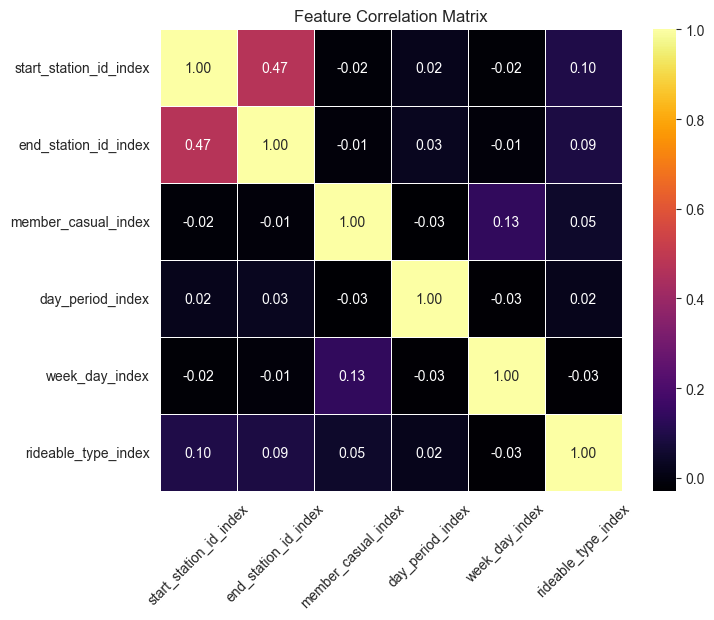

In [4]:
import seaborn as sns
import matplotlib.pyplot as plt
pd_sampled_df = sampled_df_with_added_features_indexed.toPandas()

# Plotting correlation matrix of the features
corr = pd_sampled_df[features].corr()
# Plot the heatmap
plt.figure(figsize=(8, 6))
sns.heatmap(corr, annot=True, fmt=".2f", cmap='inferno', linewidth=.5, cbar=True, square=True)
plt.title('Feature Correlation Matrix')
plt.xticks(rotation=45)
plt.savefig(os.path.join(images_path, 'selected_features_correlation_matrix.png'))
plt.show()

In [8]:
df_workdays =  sampled_df_with_added_features.filter(sampled_df_with_added_features['week_day'] == 'Workday')

df_non_workdays =  sampled_df_with_added_features.filter(sampled_df_with_added_features['week_day'] == 'non-Workday')

In [13]:
from pyspark.sql.functions import desc

"""Comparing trip records by day period and filtering by Wordays and Non-Workdays."""

df_workdays_count_day_period = df_workdays.groupBy('day_period').count().orderBy(desc('count'))
df_non_workdays_count_day_period =  df_non_workdays.groupBy('day_period').count().orderBy(desc('count'))

In [19]:
# Joining the two Spark DataFrames on 'day_period'
joined_df = df_workdays_count_day_period.withColumnRenamed('count', 'count_workday').join(df_non_workdays_count_day_period, 'day_period', 'outer') \
    .withColumnRenamed('count', 'count_non_workday')

# Convert the joined DataFrame to Pandas
pd_merged = joined_df.toPandas()


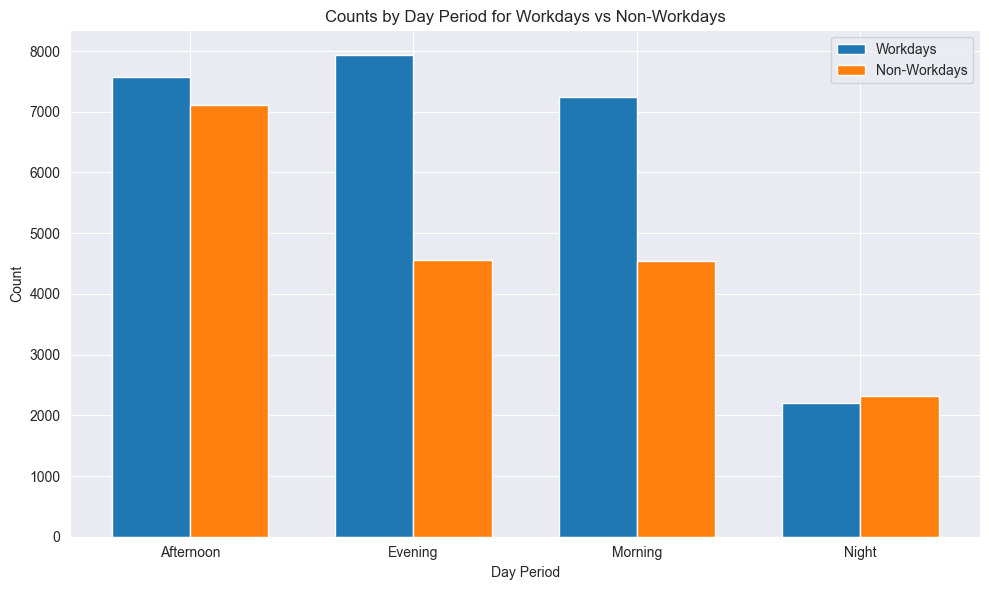

In [21]:
import matplotlib.pyplot as plt
import numpy as np

# Setting the positions and width for the bars
positions = np.arange(len(pd_merged['day_period']))
width = 0.35

# Plotting both workdays and non-workdays counts side by side
plt.figure(figsize=(10, 6))
bars_workdays = plt.bar(positions - width/2, pd_merged['count_workday'], width, label='Workdays')
bars_non_workdays = plt.bar(positions + width/2, pd_merged['count_non_workday'], width, label='Non-Workdays')

plt.xlabel('Day Period')
plt.ylabel('Count')
plt.title('Counts by Day Period for Workdays vs Non-Workdays')
plt.xticks(positions, pd_merged['day_period'])
plt.legend()
plt.tight_layout()
plt.savefig(os.path.join(images_path, 'counts_by_day_period_workdays_vs_non_workdays.png'))
plt.show()


In [37]:
"""Stations with most demand for bikes Types by working day and day period"""

from pyspark.sql.functions import desc

"""Comparing trip records by day period and filtering by Wordays and Non-Workdays and bike type."""

df_workdays_casual = df_workdays.filter(df_workdays['rideable_type'] == 'electric_bike')
df_non_workdays_casual = df_non_workdays.filter(df_workdays['rideable_type'] == 'electric_bike')
df_workdays_member = df_workdays.filter(df_workdays['rideable_type'] == 'classic_bike')
df_non_workdays_member = df_non_workdays.filter(df_non_workdays['rideable_type'] == 'classic_bike')

In [40]:
""" Bike Types Bikes by day period and workdays total trip Records """

df_workdays_count_day_period_eb = df_workdays_casual.groupBy('day_period').count().orderBy(desc('count'))
df_non_workdays_count_day_period_eb = df_non_workdays_casual.groupBy('day_period').count().orderBy(desc('count'))

df_workdays_count_day_period_cb = df_workdays_member.groupBy('day_period').count().orderBy(desc('count'))
df_non_workdays_count_day_period_cb = df_non_workdays_member.groupBy('day_period').count().orderBy(desc('count'))

In [44]:
# Joining the two Spark DataFrames on 'day_period'
member_casual_joined_df = df_workdays_count_day_period_eb.withColumnRenamed('count', 'count_eb_workdays').join(
    df_non_workdays_count_day_period_eb, 'day_period', 'outer') \
    .withColumnRenamed('count', 'count_eb_non_workdays').join(
    df_workdays_count_day_period_cb, 'day_period', 'outer') \
    .withColumnRenamed('count', 'count_cb_workdays').join(
    df_non_workdays_count_day_period_cb, 'day_period', 'outer') \
    .withColumnRenamed('count', 'count_cb_non_workdays')

# Convert the joined DataFrame to Pandas
member_casual_pd = member_casual_joined_df.toPandas()

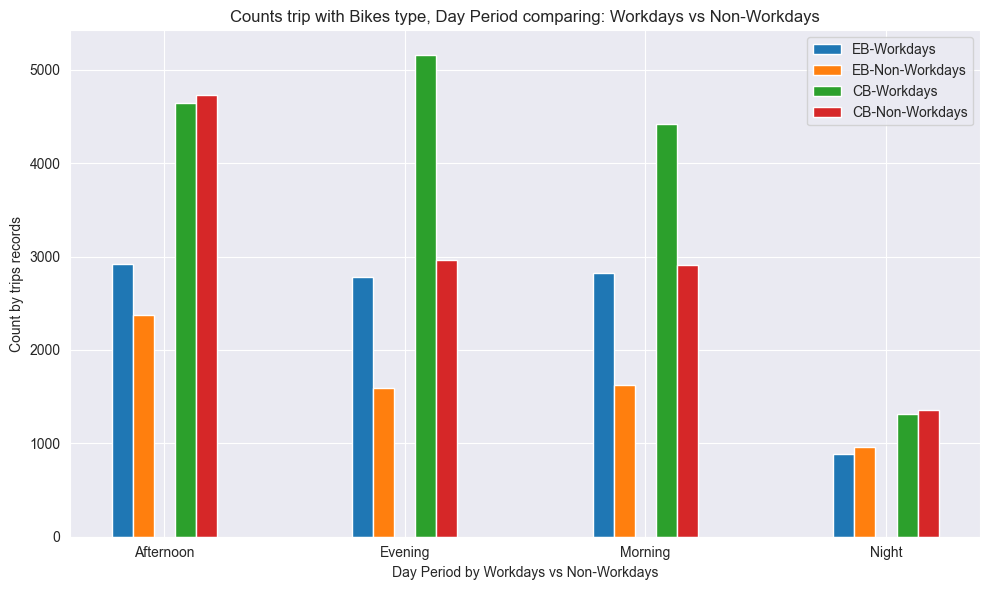

In [49]:
# Plotting parameters
positions = np.arange(len(member_casual_pd['day_period']))
width = 0.35

# Plotting
plt.figure(figsize=(10, 6))

# Plotting counts of EB bikes for both workdays and non-workdays
plt.bar(positions - width / 2, member_casual_pd['count_eb_workdays'], width / 4, label='EB-Workdays')
plt.bar(positions - width / 4, member_casual_pd['count_eb_non_workdays'], width / 4, label='EB-Non-Workdays')

# Plotting counts of CB bikes for both workdays and non-workdays
plt.bar(positions + width / 4, member_casual_pd['count_cb_workdays'], width / 4, label='CB-Workdays')
plt.bar(positions + width / 2, member_casual_pd['count_cb_non_workdays'], width / 4, label='CB-Non-Workdays')

# Adding x tick labels
plt.xticks(positions, member_casual_pd['day_period'])

plt.xlabel('Day Period by Workdays vs Non-Workdays')
plt.ylabel('Count by trips records')
plt.title('Counts trip with Bikes type, Day Period comparing: Workdays vs Non-Workdays')
plt.legend()
plt.tight_layout()
plt.savefig(os.path.join(images_path, 'counts_trips_bikes_types_by_day_period_workdays_vs_non_workdays.png'))
plt.show()

In [53]:

"""Usage patterns for by on  member_casual (One time user or Member)"""

from pyspark.sql.functions import desc, col


df_workdays_casual = df_workdays.filter(col('member_casual') == 'casual')
df_non_workdays_casual = df_non_workdays.filter(col('member_casual') == 'casual')
df_workdays_member = df_workdays.filter(col('member_casual') == 'member')
df_non_workdays_member = df_non_workdays.filter(col('member_casual') == 'member')
""" Bike Types Bikes by day period and workdays total trip Records """

df_workdays_count_day_period_casual = df_workdays_casual.groupBy('day_period').count().orderBy(desc('count'))
df_non_workdays_count_day_period_casual = df_non_workdays_casual.groupBy('day_period').count().orderBy(desc('count'))

df_workdays_count_day_period_member = df_workdays_member.groupBy('day_period').count().orderBy(desc('count'))
df_non_workdays_count_day_period_member = df_non_workdays_member.groupBy('day_period').count().orderBy(desc('count'))
# Joining the two Spark DataFrames on 'day_period'
member_casual_joined_df = df_workdays_count_day_period_casual.withColumnRenamed('count', 'count_causal_workdays').join(
    df_non_workdays_count_day_period_casual, 'day_period', 'outer') \
    .withColumnRenamed('count', 'count_causal_non_workdays').join(
    df_workdays_count_day_period_member, 'day_period', 'outer') \
    .withColumnRenamed('count', 'count_member_workdays').join(
    df_non_workdays_count_day_period_member, 'day_period', 'outer') \
    .withColumnRenamed('count', 'count_member_non_workdays')

# Convert the joined DataFrame to Pandas
member_casual_pd = member_casual_joined_df.toPandas()

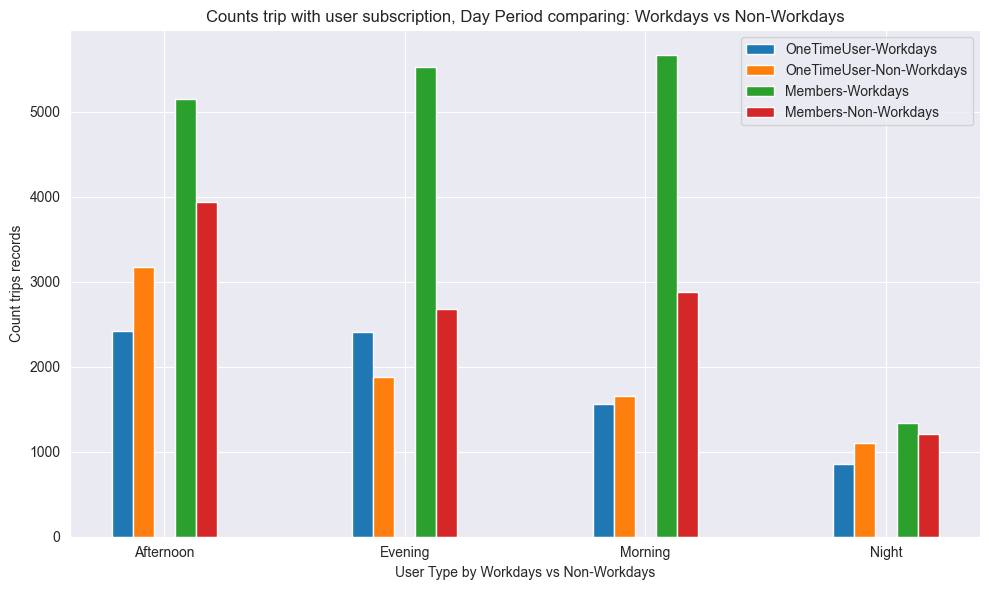

In [58]:
# Plotting parameters
positions = np.arange(len(member_casual_pd['day_period']))
width = 0.35

# Plotting
plt.figure(figsize=(10, 6))

# Plotting counts of EB bikes for both workdays and non-workdays
plt.bar(positions - width / 2, member_casual_pd['count_causal_workdays'], width / 4, label='OneTimeUser-Workdays')
plt.bar(positions - width / 4, member_casual_pd['count_causal_non_workdays'], width / 4, label='OneTimeUser-Non-Workdays')

# Plotting counts of CB bikes for both workdays and non-workdays
plt.bar(positions + width / 4, member_casual_pd['count_member_workdays'], width / 4, label='Members-Workdays')
plt.bar(positions + width / 2, member_casual_pd['count_member_non_workdays'], width / 4, label='Members-Non-Workdays')

# Adding x tick labels
plt.xticks(positions, member_casual_pd['day_period'])

plt.xlabel('User Type by Workdays vs Non-Workdays')
plt.ylabel('Count trips records')
plt.title('Counts trip with user subscription, Day Period comparing: Workdays vs Non-Workdays')
plt.legend()
plt.tight_layout()
plt.savefig(os.path.join(images_path, 'counts_trips_subscription_by_day_period_workdays_vs_non_workdays.png'))
plt.show()

In [59]:
df_casual_member = sampled_df_with_added_features.filter(col('member_casual') == 'casual')
df_member = sampled_df_with_added_features.filter(col('member_casual') == 'member')

df_rideable_type_casual_count = df_casual_member.groupBy('rideable_type').count().orderBy(desc('count'))
df_rideable_type_member_count = df_member.groupBy('rideable_type').count().orderBy(desc('count'))

In [70]:
df_rideable_type_casual_count_pandas = df_rideable_type_casual_count.toPandas()
df_rideable_type_member_count_pandas =  df_rideable_type_member_count.toPandas()

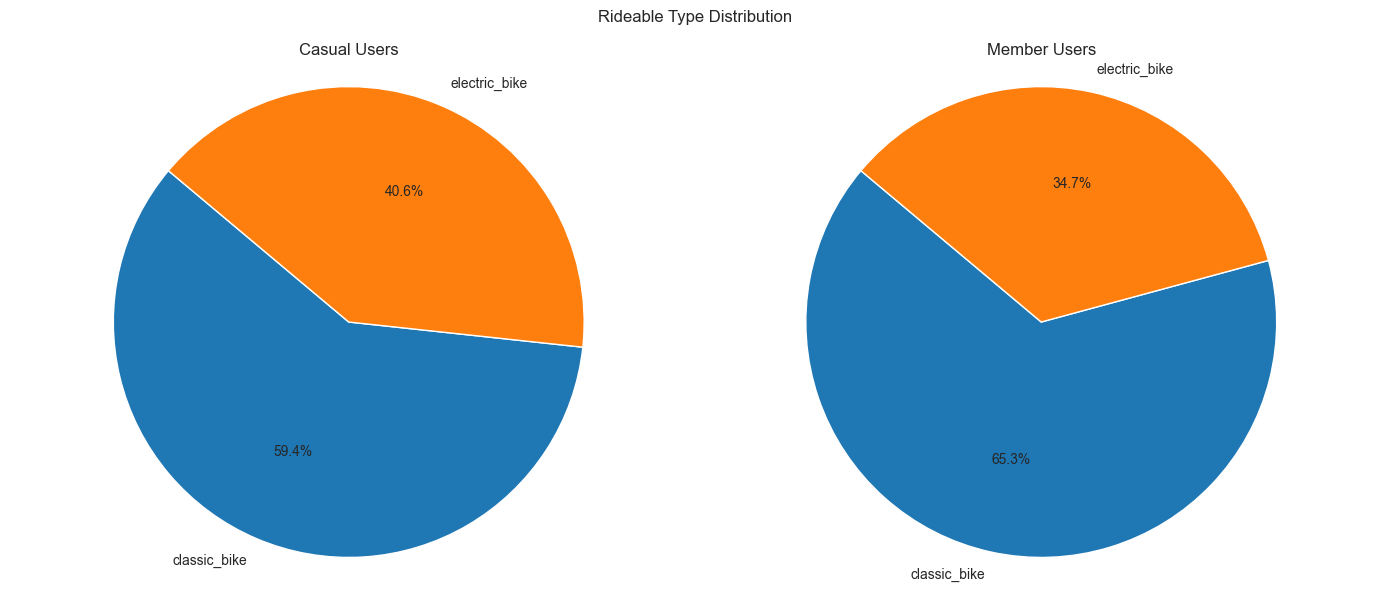

In [74]:
import matplotlib.pyplot as plt

fig, axs = plt.subplots(1, 2, figsize=(14, 6))

# Casual Users
axs[0].pie(df_rideable_type_casual_count_pandas['count'], labels=df_rideable_type_casual_count_pandas['rideable_type'], autopct='%1.1f%%', startangle=140)
axs[0].set_title('Casual Users')
axs[0].axis('equal')  # Equal aspect ratio ensures that pie is drawn as a circle.

# Member Users
axs[1].pie(df_rideable_type_member_count_pandas['count'], labels=df_rideable_type_member_count_pandas['rideable_type'], autopct='%1.1f%%', startangle=140)
axs[1].set_title('Member Users')
axs[1].axis('equal')

plt.suptitle('Rideable Type Distribution')
plt.tight_layout()
plt.savefig(os.path.join(images_path, 'pie_charts_user_selection_bike_type.png'))
plt.show()
